In [1]:
# To increase the size of the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))  # To change the cell size

# Project: Janatahack: Customer Segmentation

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers. 

You are required to help the manager to predict the right group of the new customers.

## Importing Packages

In [2]:
import pandas as pd
import os

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Setting Display size
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 300)

import missingno as msno # For visualizing missing values
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from impyute.imputation.cs import mice
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


## Importing Dataset

In [3]:
print('Current working Directory',os.getcwd())#Find out your current working directory
root = 'D:\\PrivateProjects\Customer_segmentation'
os.chdir(root)
print('Changed Working Directory',os.getcwd())#Find out your (changed) current working directory

Current working Directory D:\PrivateProjects\Customer_segmentation\scripts
Changed Working Directory D:\PrivateProjects\Customer_segmentation


### Importing data - train, test, sample_submission

In [4]:
df_train = pd.read_csv(f'{root}\data\Train_aBjfeNk.csv')
df_test = pd.read_csv(f'{root}\data\Test_LqhgPWU.csv')
df_submission = pd.read_csv(f'{root}\data\sample_submission_wyi0h0z.csv')

In [5]:
print('We have {} rows & {} columns in training dataset'.format(df_train.shape[0],df_train.shape[1] ))
print('We have {} rows & {} columns in testing dataset'.format(df_test.shape[0],df_train.shape[1]))
print('We have {} rows & {} columns in sample submission dataset'.format(df_submission.shape[0],df_train.shape[1]))

We have 8068 rows & 11 columns in training dataset
We have 2627 rows & 11 columns in testing dataset
We have 2627 rows & 11 columns in sample submission dataset


In [6]:
#To get over all idea about the columns in dataset like count of unique values, type, % of missing values

def describe_df(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=False)
    return stats_df

In [7]:
describe_df(df_train)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,8068,0.000000,0.012395,int64
1,Gender,2,0.000000,54.747149,object
2,Ever_Married,2,1.735250,57.548339,object
3,Age,67,0.000000,3.098661,int64
4,Graduated,2,0.966782,61.576599,object
5,Profession,9,1.536936,31.184928,object
6,Work_Experience,15,10.275161,29.176996,float64
7,Spending_Score,3,0.000000,60.461081,object
8,Family_Size,9,4.152206,29.623203,float64
9,Var_1,7,0.941993,64.923153,object


In [8]:
describe_df(df_test)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,2627,0.000000,0.038066,int64
1,Gender,2,0.000000,54.206319,object
2,Ever_Married,2,1.903312,57.860678,object
3,Age,67,0.000000,3.349829,int64
4,Graduated,2,0.913590,60.982109,object
5,Profession,9,1.446517,30.529121,object
6,Work_Experience,15,10.239817,29.425200,float64
7,Spending_Score,3,0.000000,61.515036,object
8,Family_Size,9,4.301485,29.234869,float64
9,Var_1,7,1.218120,63.646745,object


 - Let's combaine train & test, then remove the rows with missing columns.
 - Save the rows with the missing columns for later use.
 - Do the data processing with the remaining rows.

In [9]:
#Creating flag column to identify train & test

df_train['is_train'] = '1'
df_test['is_train'] = '0'
df_full = pd.concat([df_train, df_test])
df_full['is_train'] = df_full['is_train'].astype('int64')

### Predictive power score

The predictive power score is a summary metric for predictive relations between data series. Like correlation, it is suitable for quick data exploration. Unlike correlation, it can work with non-linear relations, categorical data, and asymmetric relations, where variable A informs on variable B more than variable B informs on variable A. Technically, the score is a measurement of the success of a Decision Tree model in predicting a target variable with the help of a predictor variable out-of-sample and relative to naïve approaches. For macro strategy development, predictive power score matrices can be easily created based on an existing python module and can increase the efficiency of finding hidden patterns in the data and selecting predictor variables.
Reference : https://www.sr-sv.com/the-predictive-power-score/

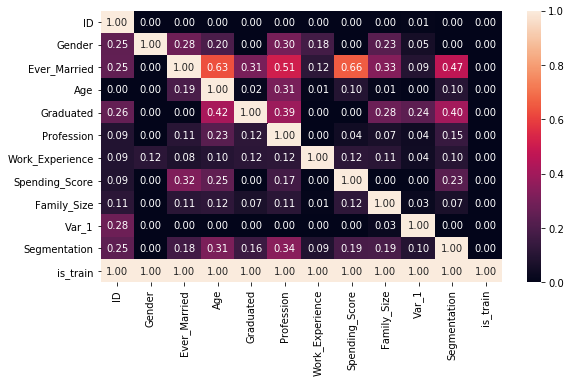

In [10]:
%matplotlib inline
plt.figure(figsize=(9,5))
sns.heatmap(pps.matrix(df_train),annot=True,fmt=".2f")

###### Insights:
            - Age has 63% correlation with Ever_Married
            - Profession has 51% good scorre with Ever_married
            - ding_Score has 66% good score with Ever_married
            - Segmentaion depends on Spending_Score, Graduated, Ever_Married
            - Its is important to fill missing values of  Ever_Married,Graduated,Profession in that order

 - How distribuded the segments are?

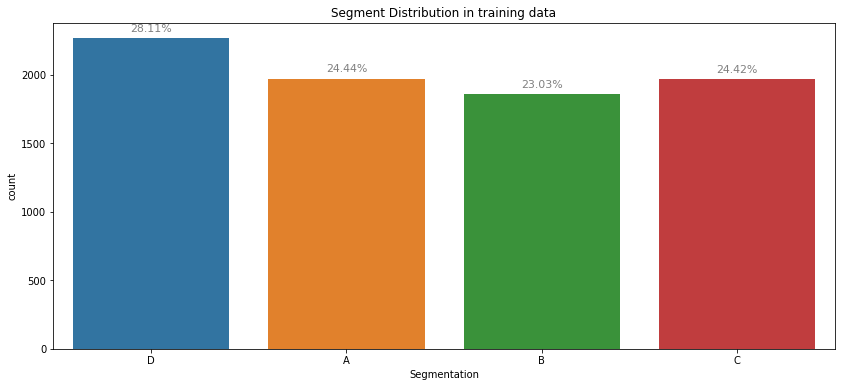

In [11]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='Segmentation', data=df_train)
plt.title('Segment Distribution in training data');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df_train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')

Answer : We can see the segments are almost equally distributed, no need to worry about sampling issues

#### Data Processing

Info:

    Binary columns : {Ever_Married, Gender, Graduated}
    Ordinal column : {Spending_Score}
    Nominal column : {Profession,Var_1, Segmentation}
    numerical column : {Age, Work_experience, Family_Size}
    id column : {ID}

In [12]:
# Create df with ID & Segment
df_id_segment = df_full[['ID','Segmentation','is_train']]
df_full.drop('Segmentation',axis = 1,inplace = True) # Dropping target
df_full.fillna('NA',inplace = True)

In [13]:
#Processing Binary Columns

gender = {'Male': 1,'Female': 0}
df_full.Gender = [gender[item] for item in df_full.Gender]

graduate = {'Yes': 1,'No': 0, 'NA':'NA'}
df_full.Graduated = [graduate[item] for item in df_full.Graduated]

ever_married = {'Yes': 1,'No': 0, 'NA':'NA'}
df_full.Ever_Married = [ever_married[item] for item in df_full.Ever_Married]

In [14]:
# Processing Ordinal column

score = {'Low' : 1 , 'Average' : 2, 'High' : 3}
df_full.Spending_Score = [score[item] for item in df_full.Spending_Score]

In [15]:
# Processing Nominal column
prof = {'Healthcare' : 1,
        'Engineer' : 2,
        'Lawyer' : 3,
        'Entertainment' : 4, 
        'Artist' : 5,
       'Executive' : 6,
        'Doctor' :7,
        'Homemaker' :8, 
        'Marketing' : 9,
        'NA' : 'NA'}

df_full.Profession = [prof[item] for item in df_full.Profession]

In [16]:
cat = {'Cat_1':1,
       'Cat_2':2,
       'Cat_3':3,
       'Cat_4':4,
       'Cat_5':5,
       'Cat_6':6,
       'Cat_7':7,
       'NA':'NA'
}

df_full.Var_1 = [cat[item] for item in df_full.Var_1]

#### Handle Missing values

The way missing values are going to be imputed by two methods and take Average.
1) MICE
2) KNN

Reference: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

In [17]:
df_full.replace('NA', np.nan,inplace = True)

##### MICE

In [18]:
# start the MICE training
imputed_training_mice=mice(df_full.values)
imputed_training_mice = pd.DataFrame(imputed_training_mice)

cols = df_full.columns # Since imputed_training is numpy array wer have to convert it to PD dataframe & assign col names
imputed_training_mice.columns = cols
imputed_training_mice[['ID','is_train']] = imputed_training_mice[['ID','is_train']].astype('int64')

In [19]:
df_processed_mice = pd.merge(imputed_training_mice,df_id_segment, how = 'inner', on =['ID','is_train'])

##### KNN

In [20]:
# start the KNN training
imputed_training_knn =fast_knn(df_full.values, k=50)
imputed_training_knn = pd.DataFrame(imputed_training_knn)

cols = df_full.columns # Since imputed_training is numpy array wer have to convert it to PD dataframe & assign col names
imputed_training_knn.columns = cols
imputed_training_knn[['ID','is_train']] = imputed_training_knn[['ID','is_train']].astype('int64')

In [21]:
df_processed_knn = pd.merge(imputed_training_knn,df_id_segment, how = 'inner', on =['ID','is_train'])

###### Now that we have imputed the missing values we can combain these two imputations & take average

List of cols with missing values : 
    - Ever_Married
    - Graduated
    - Profession
    - Work_Experience
    - Family_Size
    - var_1

In [22]:
temp = pd.concat((df_processed_knn, df_processed_mice)); 
df_final = temp.groupby(temp.index).mean()
df_final = pd.merge(df_final, df_id_segment, how = 'inner', on =['ID','is_train'] )

In [23]:
df_final.drop(['Segmentation','ID','is_train'],axis = 1, inplace = True)

In [24]:
df_final.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1'],
      dtype='object')

In [25]:
df_final = df_final.round()

In [26]:
df_final['Ever_Married']  = df_final['Ever_Married'].astype('category')
df_final['Gender']  = df_final['Gender'].astype('category')
df_final['Graduated']  = df_final['Graduated'].astype('category')
df_final['Profession']  = df_final['Profession'].astype('category')
df_final['Var_1']  = df_final['Var_1'].astype('category')

#### Preprocess

In [27]:
df_final = pd.get_dummies(df_final)

In [28]:
df_final = pd.merge(df_final,df_id_segment, how = 'inner', left_index=True, right_index=True)

In [33]:
df_final_train = df_final[df_final['is_train'] == 1]
df_final_test = df_final[df_final['is_train'] == 0]

In [34]:
df_final_train.drop(['is_train'],axis = 1,inplace = True)
df_final_test.drop(['is_train'],axis = 1,inplace = True)

In [35]:
df_final_train.to_csv('train.csv',index = False)
df_final_test.to_csv('test.csv',index = False)

### Model

In [32]:
df_final_train.drop('ID', axis = 1, inplace = True)

In [ ]:
y = df_final_train['Segmentation']
x = df_final_train.drop(['Segmentation'], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.20, random_state=27)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
classifiers = [
    LogisticRegression(random_state=1,solver="liblinear", multi_class="ovr"),
    DecisionTreeClassifier(),
    KNeighborsClassifier(4),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(hidden_layer_sizes=(500,500,500,100,100,100,100,100,100), max_iter=1000, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=21,tol=0.000000001, activation= 'relu' )
]

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(x_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

In [ ]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

##### Let's select the models with high Accuracy for max voting
 - LogisticRegression
 - RandomForestClassifier
 - AdaBoostClassifier
 - GradientBoostingClassifier
 - LinearDiscriminantAnalysis

In [ ]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state=1,solver="liblinear", multi_class="ovr")
model2 = RandomForestClassifier(n_estimators=1600,max_depth= 1000,bootstrap= True,min_samples_split= 2,
                                 min_samples_leaf= 4)
model3 = AdaBoostClassifier()
model4 = GradientBoostingClassifier(n_estimators=300)
model5 = LinearDiscriminantAnalysis()

model = VotingClassifier(estimators=[
                                        ('lr', model1),
                                        ('rc',model2),
                                        ('abc',model3),
                                        ('gbc',model4),
                                        ('lda',model5)
                                      
                                    
                                    ],
                                     voting='hard')
model.fit(x_train, y_train)
model.score( x_test, y_test)

### PyCaret

In [40]:
#import classification module
from pycaret.classification import *
#intialize the setup
exp_clf = setup(df_final_train, target = 'Segmentation',ignore_features=['ID'],normalize = True, 
                  transformation = True, 
                  ignore_low_variance = True)

Setup Succesfully Completed!


,Description,Value
0,session_id,2915
1,Target Type,Multiclass
2,Label Encoded,"A: 0, B: 1, C: 2, D: 3"
3,Original Data,"(8068, 28)"
4,Missing Values,False
5,Numeric Features,27
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [37]:
#! pip install  llvmlite --user    --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [ ]:
#! pip install   pandas --upgrade --user    --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [41]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.5222,0.0000,0.5114,0.5112,0.5128,0.3595,0.3614,1.7563
1,Extreme Gradient Boosting,0.5212,0.0000,0.5102,0.5100,0.5106,0.3580,0.3603,0.7519
2,CatBoost Classifier,0.5155,0.0000,0.5060,0.5083,0.5101,0.3512,0.3521,12.6113
3,Light Gradient Boosting Machine,0.5114,0.0000,0.5010,0.5020,0.5045,0.3453,0.3464,0.5034
4,Logistic Regression,0.5072,0.0000,0.4943,0.4901,0.4814,0.3387,0.3459,0.1940
5,Ada Boost Classifier,0.5047,0.0000,0.4947,0.4972,0.4907,0.3369,0.3414,0.7272
6,Linear Discriminant Analysis,0.5022,0.0000,0.4907,0.4904,0.4776,0.3329,0.3409,0.0667
7,Ridge Classifier,0.4967,0.0000,0.4824,0.4779,0.4564,0.3238,0.3356,0.0256
8,K Neighbors Classifier,0.4795,0.0000,0.4684,0.4650,0.4664,0.3023,0.3048,0.1178
9,Naive Bayes,0.4726,0.0000,0.4605,0.4541,0.4453,0.2931,0.3019,0.0215


### Lets tune the model

In [42]:
#Selected Model : {'Gradient Boosting Classifier','Extreme Gradient Boosting','CatBoost Classifier'}

######  Gradient Boosting Classifier

In [44]:
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5575,0.0000,0.5464,0.5455,0.5489,0.4072,0.4086
1,0.4920,0.0000,0.4816,0.4807,0.4816,0.3186,0.3207
2,0.4973,0.0000,0.4875,0.4931,0.4906,0.3259,0.3280
3,0.5451,0.0000,0.5343,0.5337,0.5359,0.3907,0.3924
4,0.5345,0.0000,0.5230,0.5248,0.5236,0.3755,0.3781
5,0.5398,0.0000,0.5287,0.5285,0.5322,0.3835,0.3845
6,0.5310,0.0000,0.5203,0.5153,0.5165,0.3704,0.3739
7,0.5000,0.0000,0.4899,0.4922,0.4924,0.3301,0.3317
8,0.5248,0.0000,0.5137,0.5084,0.5134,0.3632,0.3648
9,0.5000,0.0000,0.4888,0.4896,0.4928,0.3303,0.3312


In [46]:
tuned_gbc = tune_model(gbc_model, optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4513,0.0000,0.4425,0.4539,0.4523,0.2671,0.2672
1,0.4372,0.0000,0.4300,0.4374,0.4370,0.2476,0.2477
2,0.4566,0.0000,0.4470,0.4477,0.4510,0.2724,0.2729
3,0.5062,0.0000,0.4972,0.4996,0.5022,0.3392,0.3395
4,0.4938,0.0000,0.4852,0.4917,0.4907,0.3220,0.3229
5,0.4743,0.0000,0.4636,0.4763,0.4752,0.2978,0.2979
6,0.4566,0.0000,0.4495,0.4528,0.4543,0.2734,0.2736
7,0.4539,0.0000,0.4445,0.4474,0.4501,0.2697,0.2699
8,0.4610,0.0000,0.4521,0.4591,0.4595,0.2794,0.2795
9,0.4734,0.0000,0.4637,0.4723,0.4724,0.2961,0.2963


###### Extreme Gradient Boosting

In [47]:
xgb_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5540,0.0000,0.5429,0.5450,0.5475,0.4027,0.4038
1,0.5027,0.0000,0.4922,0.4912,0.4921,0.3328,0.3350
2,0.5062,0.0000,0.4957,0.5013,0.4952,0.3375,0.3410
3,0.5381,0.0000,0.5256,0.5225,0.5258,0.3808,0.3830
4,0.5310,0.0000,0.5196,0.5210,0.5189,0.3706,0.3736
5,0.5416,0.0000,0.5309,0.5319,0.5350,0.3859,0.3868
6,0.5062,0.0000,0.4949,0.4854,0.4905,0.3373,0.3402
7,0.5035,0.0000,0.4935,0.5005,0.4971,0.3351,0.3372
8,0.5195,0.0000,0.5090,0.5029,0.5050,0.3559,0.3589
9,0.5089,0.0000,0.4973,0.4979,0.4987,0.3417,0.3437


In [48]:
tuned_xgb = tune_model(xgb_model, optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4867,0.0000,0.4777,0.4879,0.4872,0.3144,0.3144
1,0.4637,0.0000,0.4570,0.4602,0.4612,0.2822,0.2825
2,0.4496,0.0000,0.4389,0.4407,0.4444,0.2631,0.2635
3,0.4991,0.0000,0.4902,0.4944,0.4964,0.3300,0.3301
4,0.4832,0.0000,0.4747,0.4776,0.4780,0.3075,0.3085
5,0.5150,0.0000,0.5055,0.5138,0.5144,0.3519,0.3520
6,0.4885,0.0000,0.4827,0.4848,0.4862,0.3164,0.3166
7,0.4574,0.0000,0.4486,0.4552,0.4561,0.2750,0.2751
8,0.4894,0.0000,0.4800,0.4827,0.4855,0.3172,0.3174
9,0.4752,0.0000,0.4653,0.4704,0.4722,0.2980,0.2982


###### CatBoost Classifier

In [49]:
cbc_model = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5239,0.0000,0.5136,0.5155,0.5183,0.3625,0.3631
1,0.5115,0.0000,0.5041,0.5075,0.5082,0.3459,0.3465
2,0.4726,0.0000,0.4625,0.4669,0.4664,0.2932,0.2947
3,0.5611,0.0000,0.5516,0.5539,0.5554,0.4122,0.4132
4,0.5133,0.0000,0.5043,0.5080,0.5075,0.3480,0.3494
5,0.5416,0.0000,0.5309,0.5346,0.5376,0.3867,0.3870
6,0.5133,0.0000,0.5045,0.5029,0.5050,0.3477,0.3492
7,0.4823,0.0000,0.4723,0.4740,0.4769,0.3073,0.3079
8,0.5018,0.0000,0.4916,0.4921,0.4961,0.3331,0.3336
9,0.5337,0.0000,0.5245,0.5278,0.5300,0.3758,0.3762


In [50]:
tuned_cbc = tune_model(cbc_model, optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5434,0.0000,0.5333,0.5362,0.5376,0.3885,0.3897
1,0.5221,0.0000,0.5115,0.5135,0.5107,0.3588,0.3619
2,0.4956,0.0000,0.4848,0.4880,0.4874,0.3233,0.3253
3,0.5628,0.0000,0.5517,0.5508,0.5517,0.4141,0.4166
4,0.5327,0.0000,0.5217,0.5257,0.5222,0.3731,0.3761
5,0.5398,0.0000,0.5283,0.5298,0.5332,0.3837,0.3845
6,0.5327,0.0000,0.5221,0.5207,0.5226,0.3735,0.3756
7,0.5018,0.0000,0.4918,0.4951,0.4940,0.3327,0.3345
8,0.5319,0.0000,0.5217,0.5184,0.5229,0.3732,0.3744
9,0.5230,0.0000,0.5131,0.5173,0.5175,0.3609,0.3621


In [54]:
blend_specific_soft = blend_models(estimator_list = [tuned_gbc,tuned_xgb], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4726,0.0000,0.4653,0.4884,0.4769,0.2966,0.2983
1,0.4442,0.0000,0.4387,0.4586,0.4487,0.2583,0.2595
2,0.4513,0.0000,0.4436,0.4555,0.4510,0.2672,0.2684
3,0.5080,0.0000,0.5013,0.5159,0.5101,0.3432,0.3441
4,0.4920,0.0000,0.4857,0.5028,0.4936,0.3210,0.3231
5,0.4920,0.0000,0.4849,0.5127,0.4991,0.3229,0.3243
6,0.4637,0.0000,0.4591,0.4698,0.4633,0.2846,0.2861
7,0.4681,0.0000,0.4612,0.4750,0.4704,0.2903,0.2907
8,0.4734,0.0000,0.4667,0.4885,0.4787,0.2977,0.2987
9,0.4840,0.0000,0.4766,0.4975,0.4859,0.3119,0.3142


In [55]:
blend_specific_soft = blend_models(estimator_list = [tuned_gbc,tuned_xgb], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4726,0.0000,0.4653,0.4884,0.4769,0.2966,0.2983
1,0.4442,0.0000,0.4387,0.4586,0.4487,0.2583,0.2595
2,0.4513,0.0000,0.4436,0.4555,0.4510,0.2672,0.2684
3,0.5080,0.0000,0.5013,0.5159,0.5101,0.3432,0.3441
4,0.4920,0.0000,0.4857,0.5028,0.4936,0.3210,0.3231
5,0.4920,0.0000,0.4849,0.5127,0.4991,0.3229,0.3243
6,0.4637,0.0000,0.4591,0.4698,0.4633,0.2846,0.2861
7,0.4681,0.0000,0.4612,0.4750,0.4704,0.2903,0.2907
8,0.4734,0.0000,0.4667,0.4885,0.4787,0.2977,0.2987
9,0.4840,0.0000,0.4766,0.4975,0.4859,0.3119,0.3142


In [56]:
stack_hard = stack_models([tuned_gbc,tuned_xgb], method='hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5381,0.0000,0.5269,0.5274,0.5257,0.3812,0.3846
1,0.4779,0.0000,0.4666,0.4589,0.4606,0.2999,0.3035
2,0.4956,0.0000,0.4832,0.4795,0.4810,0.3228,0.3258
3,0.5186,0.0000,0.5073,0.5096,0.5038,0.3546,0.3589
4,0.4973,0.0000,0.4849,0.4807,0.4812,0.3255,0.3289
5,0.5292,0.0000,0.5168,0.5168,0.5160,0.3693,0.3726
6,0.4938,0.0000,0.4833,0.4733,0.4783,0.3212,0.3239
7,0.4965,0.0000,0.4859,0.5028,0.4837,0.3253,0.3307
8,0.5142,0.0000,0.5028,0.4952,0.4971,0.3493,0.3531
9,0.5160,0.0000,0.5039,0.5038,0.5041,0.3517,0.3546


In [57]:
stack_soft2 = stack_models([tuned_gbc,tuned_xgb], meta_model=tuned_xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5451,0.0000,0.5346,0.5350,0.5383,0.3909,0.3918
1,0.4850,0.0000,0.4784,0.4860,0.4849,0.3114,0.3116
2,0.5150,0.0000,0.5077,0.5122,0.5128,0.3510,0.3514
3,0.5558,0.0000,0.5488,0.5540,0.5541,0.4058,0.4062
4,0.5504,0.0000,0.5430,0.5465,0.5474,0.3984,0.3989
5,0.5416,0.0000,0.5329,0.5373,0.5390,0.3871,0.3873
6,0.5168,0.0000,0.5101,0.5120,0.5135,0.3534,0.3539
7,0.5071,0.0000,0.4986,0.5044,0.5056,0.3411,0.3412
8,0.5585,0.0000,0.5505,0.5538,0.5547,0.4091,0.4098
9,0.5160,0.0000,0.5080,0.5121,0.5130,0.3520,0.3525


In [58]:
final_stack_soft = finalize_model(stack_soft2)

C:\Users\balaji\AppData\Roaming\Python\Python37\site-packages\pycaret\classification.py:7546: UserWarning:

This function will adopt to Stackingclassifer() from sklearn in future release of PyCaret 2.x.



In [59]:
df_final_test.head()

,Age,Work_Experience,Spending_Score,Family_Size,Gender_0.0,Gender_1.0,Ever_Married_0.0,Ever_Married_1.0,Graduated_0.0,Graduated_1.0,...,Profession_9.0,Var_1_1.0,Var_1_2.0,Var_1_3.0,Var_1_4.0,Var_1_5.0,Var_1_6.0,Var_1_7.0,ID,Segmentation
0,22.0,1.0,1.0,4.0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,458989,NaN
1,38.0,3.0,2.0,3.0,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,458994,NaN
2,67.0,1.0,1.0,1.0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,458996,NaN
3,67.0,0.0,3.0,2.0,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,459000,NaN
4,40.0,4.0,3.0,6.0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,459001,NaN


In [60]:
unseen_predictions = predict_model(final_stack_soft, data=df_final_test)
unseen_predictions.head()

,Age,Work_Experience,Spending_Score,Family_Size,Gender_0.0,Gender_1.0,Ever_Married_0.0,Ever_Married_1.0,Graduated_0.0,Graduated_1.0,...,Var_1_2.0,Var_1_3.0,Var_1_4.0,Var_1_5.0,Var_1_6.0,Var_1_7.0,ID,Segmentation,Label,Score
0,22.0,1.0,1.0,4.0,0,1,1,0,1,0,...,0,0,1,0,0,0,458989,NaN,0,0.5136
1,38.0,3.0,2.0,3.0,1,0,0,1,0,1,...,0,0,1,0,0,0,458994,NaN,3,0.6521
2,67.0,1.0,1.0,1.0,1,0,0,1,0,1,...,0,0,0,0,1,0,458996,NaN,0,0.4422
3,67.0,0.0,3.0,2.0,0,1,0,1,0,1,...,0,0,0,0,1,0,459000,NaN,1,0.6827
4,40.0,4.0,3.0,6.0,1,0,0,1,0,1,...,0,0,0,0,1,0,459001,NaN,3,0.6521


In [62]:
unseen_predictions = unseen_predictions[['ID','Label']]

In [69]:
label = {0: 'A',
        1:'B',
        2:'C',
        3:'D'}

unseen_predictions.Label = [label[item] for item in unseen_predictions.Label]

In [71]:
unseen_predictions.to_csv('final_submission.csv',index = False)